In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# pip install numpy pandas scikit-learn tensorflow

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import random
import os
import torch.nn.functional as F
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    torch.use_deterministic_algorithms(True)

# ---------------------- Load data ----------------------
def load_data_new(seed):
    X_data_train = pd.read_csv('/content/drive/MyDrive/CaReTS/prs_HWM_train.csv')
    Y_data_train = X_data_train

    X_train_full = X_data_train.iloc[:, 0:15].values
    y_train_full = Y_data_train.iloc[:, 15:21].values # six steps

    X_train_time = X_train_full[:, :3].astype(np.float32)
    X_train_seq = X_train_full[:, 3:].astype(np.float32)

    X_train_time[:, 0] /= 23.0
    X_train_time[:, 1] /= 7.0
    X_train_time[:, 2] /= 12.0

    X_seq_min, X_seq_max = X_train_seq.min(axis=0), X_train_seq.max(axis=0)
    y_min, y_max = y_train_full.min(axis=0), y_train_full.max(axis=0)

    X_train_seq_scaled = (X_train_seq - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    y_train_scaled = (y_train_full - y_min) / (y_max - y_min + 1e-8)

    X_train_combined = np.concatenate([X_train_time, X_train_seq_scaled], axis=1)

    trend_labels = (y_train_full > X_train_seq[:, -1].reshape(-1, 1)).astype(int)

    X_train_tensor = torch.tensor(X_train_combined, dtype=torch.float32).unsqueeze(-1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    trend_tensor = torch.tensor(trend_labels, dtype=torch.long)

    dataset = TensorDataset(X_train_tensor, y_train_tensor, trend_tensor)

    # Test set
    X_data_test = pd.read_csv('/content/drive/MyDrive/CaReTS/prs_HWM_test.csv')
    Y_data_test = X_data_test

    X_test_full = X_data_test.iloc[:, 0:15].values
    y_test_full = Y_data_test.iloc[:, 15:21].values # six steps

    X_test_time = X_test_full[:, :3].astype(np.float32)
    X_test_seq = X_test_full[:, 3:].astype(np.float32)

    X_test_time[:, 0] /= 23.0
    X_test_time[:, 1] /= 7.0
    X_test_time[:, 2] /= 12.0

    X_test_seq_scaled = (X_test_seq - X_seq_min) / (X_seq_max - X_seq_min + 1e-8)
    y_test_scaled = (y_test_full - y_min) / (y_max - y_min + 1e-8)

    X_test_combined = np.concatenate([X_test_time, X_test_seq_scaled], axis=1)

    trend_labels_test = (y_test_full > X_test_seq[:, -1].reshape(-1, 1)).astype(int)

    X_test_tensor = torch.tensor(X_test_combined, dtype=torch.float32).unsqueeze(-1)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    trend_test_tensor = torch.tensor(trend_labels_test, dtype=torch.long)

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, trend_test_tensor)

    return dataset, test_dataset, (X_seq_min, X_seq_max, y_min, y_max)

# --------- Encoder models ---------
class MultiStepTrendDeltaModel(nn.Module):
    # def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=3, model_type='LSTM'):
    # def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, model_type='CNN'):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2, output_len=6, model_type='TRANSFORMER'):
        super().__init__()
        self.output_len = output_len
        self.model_type = model_type.upper()

        if self.model_type == 'LSTM':
            self.feature_extractor = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        elif self.model_type == 'CNN':
            self.feature_extractor = nn.Sequential(
                nn.Conv1d(in_channels=input_dim, out_channels=32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(32, hidden_dim, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.AdaptiveAvgPool1d(1)  # Output shape：[B, hidden_dim, 1]
            )

        elif self.model_type == 'TRANSFORMER':
            self.input_projection = nn.Linear(input_dim, hidden_dim)

            self.pos_embedding = nn.Parameter(torch.randn(1, 25, hidden_dim))

            encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=4, batch_first=True)
            self.feature_extractor = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        else:
            raise ValueError(f"Unknown type: {self.model_type}")

        # Classification stream
        self.trend_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_len)
        )

        # Regression stream
        self.delta_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_len)
        )

    def forward(self, x, curr):
        if self.model_type == 'LSTM':
            out, _ = self.feature_extractor(x)
            h = out[:, -1, :]  # [B, hidden_dim]

        elif self.model_type == 'CNN':
            x_cnn = x.permute(0, 2, 1)
            out = self.feature_extractor(x_cnn)  # [B, hidden_dim, 1]
            h = out.squeeze(-1)  # [B, hidden_dim]

        elif self.model_type == 'TRANSFORMER':
            x_proj = self.input_projection(x)  # [B, seq_len, hidden_dim]
            seq_len = x_proj.size(1)
            pos_embed = self.pos_embedding[:, :seq_len, :]
            x_proj = x_proj + pos_embed
            out = self.feature_extractor(x_proj)
            h = out[:, -1, :]

        else:
            raise ValueError("Unsupported type")

        trend_logits = self.trend_branch(h)  # [B, output_len]
        delta = self.delta_branch(h)         # [B, output_len]

        trend_probs = torch.sigmoid(trend_logits)
        trend_dir = torch.where(trend_probs > 0.5, 1.0, -1.0)

        # fusion
        pred = curr.unsqueeze(1) + trend_dir * delta  # [B, output_len]

        return pred, trend_logits, delta

# --------- loss ---------
def compute_loss(pred, trend_logits, delta, target, trend_label, curr, loss_weighting=None):

    loss_cls = F.binary_cross_entropy_with_logits(trend_logits, trend_label)

    true_delta = torch.abs(target - curr.unsqueeze(1))
    loss_delta = F.l1_loss(delta, true_delta)

    loss_pred = F.l1_loss(pred, target)



    if loss_weighting is not None:
        loss_total, loss_with_reg = loss_weighting(loss_pred, loss_delta, loss_cls)
    else:
        lambda_cls, lambda_delta, lambda_pred = 1.0, 1.0, 1.0
        loss_with_reg = lambda_cls * loss_cls + lambda_delta * loss_delta + lambda_pred * loss_pred
        loss_total = loss_with_reg

    return loss_with_reg, loss_cls, loss_delta, loss_pred

# --------- uncertainty-aware weighting  ---------
class MultiTaskLossUncertainty3(nn.Module):
    def __init__(self, min_logvar=-10, max_logvar=10):
        super().__init__()
        self.log_var_pred = nn.Parameter(torch.tensor([-0.5]))   # loss_pred
        self.log_var_delta = nn.Parameter(torch.tensor([-0.5]))  # loss_delta
        self.log_var_cls = nn.Parameter(torch.tensor([-0.5]))    # loss_cls

        self.min_logvar = min_logvar
        self.max_logvar = max_logvar

    def forward(self, loss_pred, loss_delta, loss_cls):
        # Limit the range of log_var to avoid gradient explosion
        log_var_pred = torch.clamp(self.log_var_pred, self.min_logvar, self.max_logvar)
        log_var_delta = torch.clamp(self.log_var_delta, self.min_logvar, self.max_logvar)
        log_var_cls = torch.clamp(self.log_var_cls, self.min_logvar, self.max_logvar)

        precision_pred = torch.exp(-log_var_pred)
        precision_delta = torch.exp(-log_var_delta)
        precision_cls = torch.exp(-log_var_cls)

        # core
        loss_combined = (
            0.5 * (precision_pred * loss_pred + log_var_pred) +
            0.5 * (precision_delta * loss_delta + log_var_delta) +
            0.5 * (precision_cls * loss_cls + log_var_cls)
        )

        # regularization
        reg = 1e-4 * (log_var_pred**2 + log_var_delta**2 + log_var_cls**2)

        return loss_combined, loss_combined + reg

# --------- Evaluation  ---------
def evaluate_model(model, data_loader, y_min, y_max):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for X_batch, y_batch, trend_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            trend_batch = trend_batch.to(device)
            curr = X_batch[:, -1, 0]
            y_pred_scaled, trend_logits,_ = model(X_batch, curr)
            preds.append(y_pred_scaled.cpu().numpy())
            trues.append(y_batch.cpu().numpy())
    preds = np.vstack(preds)
    trues = np.vstack(trues)
    y_pred = preds * (y_max - y_min + 1e-8) + y_min
    y_true = trues * (y_max - y_min + 1e-8) + y_min
    mse_per_output = mean_squared_error(y_true, y_pred, multioutput='raw_values')
    mse_total = np.mean(mse_per_output)
    rmse_total = np.sqrt(mse_total)
    return mse_per_output, mse_total, rmse_total, y_true, y_pred


def pad_epochs(list_of_epoch_lists, fill_value=None):
    max_len = max(len(l) for l in list_of_epoch_lists)
    padded = []
    for l in list_of_epoch_lists:
        if len(l) < max_len:
            if len(l) > 0:
                padded.append(l + [l[-1]] * (max_len - len(l)))
            else:
                padded.append([fill_value] * max_len)
        else:
            padded.append(l)
    return np.array(padded, dtype=np.float32)

In [ ]:
# Main training
num_folds = 10
num_epochs = 600
batch_size = 64
base_seed = 2025


full_dataset, test_dataset, (X_min, X_max, y_min, y_max) = load_data_new(seed=base_seed)

full_dataset, test_dataset, (X_min, X_max, y_min, y_max) = load_data_new(seed=base_seed)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


kf = KFold(n_splits=num_folds, shuffle=True, random_state=base_seed)

train_mse_all = []
val_mse_all = []
train_rmse_all = []
val_rmse_all = []
test_mse_per_output_all = []
test_mse_total_all = []
test_rmse_total_all = []

# Save the training/validation MSE list of all folds
train_mse_per_epoch_all = []
val_mse_per_epoch_all = []

fold_idx = 0
start = time.time()
for train_idx, val_idx in kf.split(range(len(full_dataset))):
    fold_idx += 1
    # print(f'Fold {fold_idx}/{num_folds}')

    set_seed(base_seed + fold_idx)

    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    model = MultiStepTrendDeltaModel().to(device)
    uncertainty_loss_module = MultiTaskLossUncertainty3().to(device)
    optimizer = torch.optim.Adam(list(model.parameters()) + list(uncertainty_loss_module.parameters()), lr=0.001)

    mse_loss = nn.MSELoss()
    ce_loss = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    patience = 50
    counter = 0

    train_mse_per_epoch = []
    val_mse_per_epoch = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        total_loss_reg = 0
        total_loss_cls = 0
        total_loss_delta = 0

        for X_batch, y_batch, trend_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            trend_batch = trend_batch.to(device)
            optimizer.zero_grad()
            curr = X_batch[:, -1, 0]
            pred, trend_logits, delta = model(X_batch, curr)

            # Compute multi-task losses with uncertainty
            loss_total, loss_cls, loss_delta, loss_pred = compute_loss(
                pred, trend_logits, delta, y_batch, trend_batch.float(), curr, loss_weighting=uncertainty_loss_module
            )
            loss_total.backward()

            optimizer.step()

            total_loss += loss_total.item() * X_batch.size(0)
            total_loss_reg += loss_pred.item() * X_batch.size(0)
            total_loss_cls += loss_cls.item() * X_batch.size(0)
            total_loss_delta += loss_delta.item() * X_batch.size(0)


        avg_loss_pred = total_loss_reg / len(train_loader.dataset)
        avg_loss_cls = total_loss_cls / len(train_loader.dataset)
        avg_loss_delta = total_loss_delta / len(train_loader.dataset)
        avg_train_loss = total_loss / len(train_loader.dataset)

        # if (epoch+1) % 10 == 0 or epoch == 0:
        #     print(f"Epoch {epoch+1} - Loss Pred: {avg_loss_pred:.6f} - Loss Delta: {avg_loss_delta:.6f} - Loss Cls: {avg_loss_cls:.6f} - Total: {avg_train_loss:.6f}")
        #     print(f"\t[log_var_pred: {uncertainty_loss_module.log_var_pred.item():.4f} | log_var_delta: {uncertainty_loss_module.log_var_delta.item():.4f} | log_var_cls: {uncertainty_loss_module.log_var_cls.item():.4f}]")



        # train MSE calculation
        model.eval()
        total_train_mse = 0
        with torch.no_grad():
            for X_batch, y_batch, _ in train_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # trend_batch = trend_batch.to(device)
                curr = X_batch[:, -1, 0]
                y_pred, _, _ = model(X_batch, curr)
                mse = mse_loss(y_pred, y_batch)
                total_train_mse += mse.item() * X_batch.size(0)
        train_mse = total_train_mse / len(train_loader.dataset)
        train_mse_per_epoch.append(train_mse)

        # val MSE calculation
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch, _ in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # trend_batch = trend_batch.to(device)
                curr = X_batch[:, -1, 0]
                y_pred, _, _ = model(X_batch, curr)
                mse = mse_loss(y_pred, y_batch)
                val_loss += mse.item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        val_mse_per_epoch.append(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            best_model_state = model.state_dict()
        else:
            counter += 1
            if counter >= patience:
                # print(f"Early stopping at epoch {epoch+1}")
                break

    # Save the training/validation MSE curve of each epoch
    train_mse_per_epoch_all.append(train_mse_per_epoch)
    val_mse_per_epoch_all.append(val_mse_per_epoch)

    model.load_state_dict(best_model_state)

    # Final training MSE
    model.eval()
    total_train_mse = 0
    with torch.no_grad():
        for X_batch, y_batch, _ in train_loader:

            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # trend_batch = trend_batch.to(device)
            curr = X_batch[:, -1, 0]
            y_pred, _, _ = model(X_batch, curr)
            mse = mse_loss(y_pred, y_batch)
            total_train_mse += mse.item() * X_batch.size(0)
    train_mse_final = total_train_mse / len(train_loader.dataset)
    train_rmse_final = np.sqrt(train_mse_final)

    # Final validation MSE
    val_loss_final = 0
    with torch.no_grad():
        for X_batch, y_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            # trend_batch = trend_batch.to(device)
            curr = X_batch[:, -1, 0]
            y_pred, _, _ = model(X_batch, curr)
            mse = mse_loss(y_pred, y_batch)
            val_loss_final += mse.item() * X_batch.size(0)
    val_loss_final /= len(val_loader.dataset)
    val_rmse_final = np.sqrt(val_loss_final)

    # Test
    mse_per_output, mse_total, rmse_total, y_true, y_pred = evaluate_model(model, test_loader, y_min, y_max)

    # Trend accuracy at each time step
    with torch.no_grad():
        total_correct = 0
        total = 0
        correct_per_step = None

        for X_batch, _, trend_label in test_loader:
            X_batch = X_batch.to(device)

            trend_label = trend_label.to(device)
            curr = X_batch[:, -1, 0]
            _, trend_logits, _ = model(X_batch, curr)
            probs = torch.sigmoid(trend_logits)
            preds = (probs > 0.5).long()

            if correct_per_step is None:
                correct_per_step = torch.zeros(preds.size(1))
                total_per_step = torch.zeros(preds.size(1))

            correct = (preds == trend_label).int()
            correct_per_step += correct.sum(dim=0).cpu()
            total_per_step += torch.tensor(trend_label.size(0))

            total_correct += correct.sum().item()
            total += trend_label.numel()

        acc_total = total_correct / total
        acc_per_step = correct_per_step / total_per_step

        # print(f"Fold {fold_idx} - Trend Accuracy (Total): {acc_total:.4f}")
        # for i, acc in enumerate(acc_per_step):
        #     print(f"\tStep {i+1} Accuracy: {acc:.4f}")

        if fold_idx == 1:
            trend_accuracy_all = [acc_total]
            trend_accuracy_per_step_all = [acc_per_step.numpy()]
        else:
            trend_accuracy_all.append(acc_total)
            trend_accuracy_per_step_all.append(acc_per_step.numpy())


    train_mse_all.append(train_mse_final)
    val_mse_all.append(val_loss_final)
    train_rmse_all.append(train_rmse_final)
    val_rmse_all.append(val_rmse_final)
    test_mse_per_output_all.append(mse_per_output)
    test_mse_total_all.append(mse_total)
    test_rmse_total_all.append(rmse_total)

    # Save the results of the last fold for drawing
    if fold_idx == num_folds:
        y_true_test_final = y_true
        y_pred_test_final = y_pred
        last_train_losses = train_mse_per_epoch
        last_val_losses = val_mse_per_epoch

    # print(f"Fold {fold_idx} - Train MSE: {train_mse_final:.6f}, RMSE: {train_rmse_final:.6f}")
    # print(f"Fold {fold_idx} - Val MSE: {val_loss_final:.6f}, RMSE: {val_rmse_final:.6f}")
    # print(f"Fold {fold_idx} - Test Total MSE: {mse_total:.6f}, RMSE: {rmse_total:.6f}")

end = time.time()
print(f"Time: {(end - start)/num_folds:.6f} s")

# MSE/RMSE & STD
train_mse_all = np.array(train_mse_all)
val_mse_all = np.array(val_mse_all)
train_rmse_all = np.array(train_rmse_all)
val_rmse_all = np.array(val_rmse_all)
test_mse_total_all = np.array(test_mse_total_all)
test_rmse_total_all = np.array(test_rmse_total_all)
test_mse_per_output_all = np.array(test_mse_per_output_all)

print("\nFinal Results (mean ± std over folds):")
print(f"Train Total MSE: {train_mse_all.mean():.6f} ± {train_mse_all.std():.6f} | RMSE: {train_rmse_all.mean():.6f} ± {train_rmse_all.std():.6f}")
print(f"Validation Total MSE: {val_mse_all.mean():.6f} ± {val_mse_all.std():.6f} | RMSE: {val_rmse_all.mean():.6f} ± {val_rmse_all.std():.6f}")
print(f"Test Total MSE: {test_mse_total_all.mean():.6f} ± {test_mse_total_all.std():.6f} | RMSE: {test_rmse_total_all.mean():.6f} ± {test_rmse_total_all.std():.6f}")

# Trend accuracy
trend_accuracy_all = np.array(trend_accuracy_all)
trend_accuracy_per_step_all = np.array(trend_accuracy_per_step_all)

print(f"Test Trend Accuracy (Total): {trend_accuracy_all.mean():.4f} ± {trend_accuracy_all.std():.4f}")
for i in range(trend_accuracy_per_step_all.shape[1]):
    acc_step_mean = trend_accuracy_per_step_all[:, i].mean()
    acc_step_std = trend_accuracy_per_step_all[:, i].std()
    print(f"Step {i+1} Accuracy: {acc_step_mean:.4f} ± {acc_step_std:.4f}")



Time: 357.198925 s

Final Results (mean ± std over folds):
Train Total MSE: 0.001167 ± 0.000110 | RMSE: 0.034129 ± 0.001582
Validation Total MSE: 0.001982 ± 0.000227 | RMSE: 0.044442 ± 0.002557
Test Total MSE: 0.002238 ± 0.000098 | RMSE: 0.047297 ± 0.001037
Test Trend Accuracy (Total): 0.9142 ± 0.0029
Step 1 Accuracy: 0.8805 ± 0.0033
Step 2 Accuracy: 0.9032 ± 0.0039
Step 3 Accuracy: 0.9221 ± 0.0066
Step 4 Accuracy: 0.9260 ± 0.0040
Step 5 Accuracy: 0.9240 ± 0.0024
Step 6 Accuracy: 0.9291 ± 0.0038


In [ ]:
# Convert to numpy array
train_mse_all = np.array(train_mse_all)
val_mse_all = np.array(val_mse_all)
test_mse_per_output_all = np.array(test_mse_per_output_all)
test_mse_total_all = np.array(test_mse_total_all)

train_mse_mean = train_mse_all.mean()
train_mse_std = train_mse_all.std()
val_mse_mean = val_mse_all.mean()
val_mse_std = val_mse_all.std()


train_rmse_all = np.sqrt(train_mse_all)
val_rmse_all = np.sqrt(val_mse_all)
test_rmse_all = np.sqrt(test_mse_total_all)

train_rmse_mean = train_rmse_all.mean()
train_rmse_std = train_rmse_all.std()
val_rmse_mean = val_rmse_all.mean()
val_rmse_std = val_rmse_all.std()
test_rmse_mean = test_rmse_all.mean()
test_rmse_std = test_rmse_all.std()

print("Final Results (mean ± std over runs):")
print(f"Train Total MSE: {train_mse_mean:.6f} ± {train_mse_std:.6f} | RMSE: {train_rmse_mean:.6f} ± {train_rmse_std:.6f}")
print(f"Validation Total MSE: {val_mse_mean:.6f} ± {val_mse_std:.6f} | RMSE: {val_rmse_mean:.6f} ± {val_rmse_std:.6f}")
print(f"Test Total MSE: {test_mse_total_all.mean():.6f} ± {test_mse_total_all.std():.6f} | RMSE: {test_rmse_mean:.6f} ± {test_rmse_std:.6f}")

# for i in range(test_mse_per_output_all.shape[1]):
#     print(f"Test Output {i+1} MSE: {test_mse_per_output_all[:, i].mean():.6f} ± {test_mse_per_output_all[:, i].std():.6f}")

# RMSE（mean ± std）
test_rmse_per_output_all = np.sqrt(test_mse_per_output_all)

for i in range(test_rmse_per_output_all.shape[1]):
    mean_rmse = test_rmse_per_output_all[:, i].mean()
    std_rmse = test_rmse_per_output_all[:, i].std()
    print(f"Test Output {i+1} RMSE: {mean_rmse:.6f} ± {std_rmse:.6f}")


Final Results (mean ± std over runs):
Train Total MSE: 0.001167 ± 0.000110 | RMSE: 0.034129 ± 0.001582
Validation Total MSE: 0.001982 ± 0.000227 | RMSE: 0.044442 ± 0.002557
Test Total MSE: 0.002238 ± 0.000098 | RMSE: 0.047297 ± 0.001037
Test Output 1 RMSE: 0.029416 ± 0.000935
Test Output 2 RMSE: 0.039841 ± 0.001673
Test Output 3 RMSE: 0.046472 ± 0.001587
Test Output 4 RMSE: 0.051525 ± 0.001260
Test Output 5 RMSE: 0.054259 ± 0.001403
Test Output 6 RMSE: 0.056614 ± 0.001497


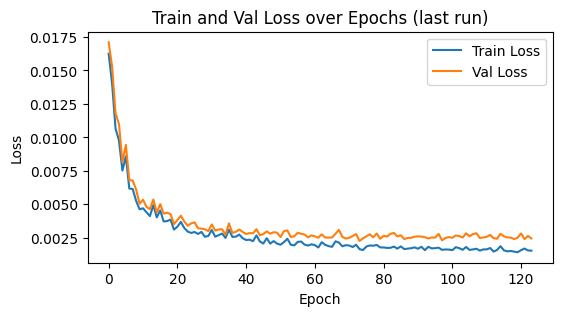

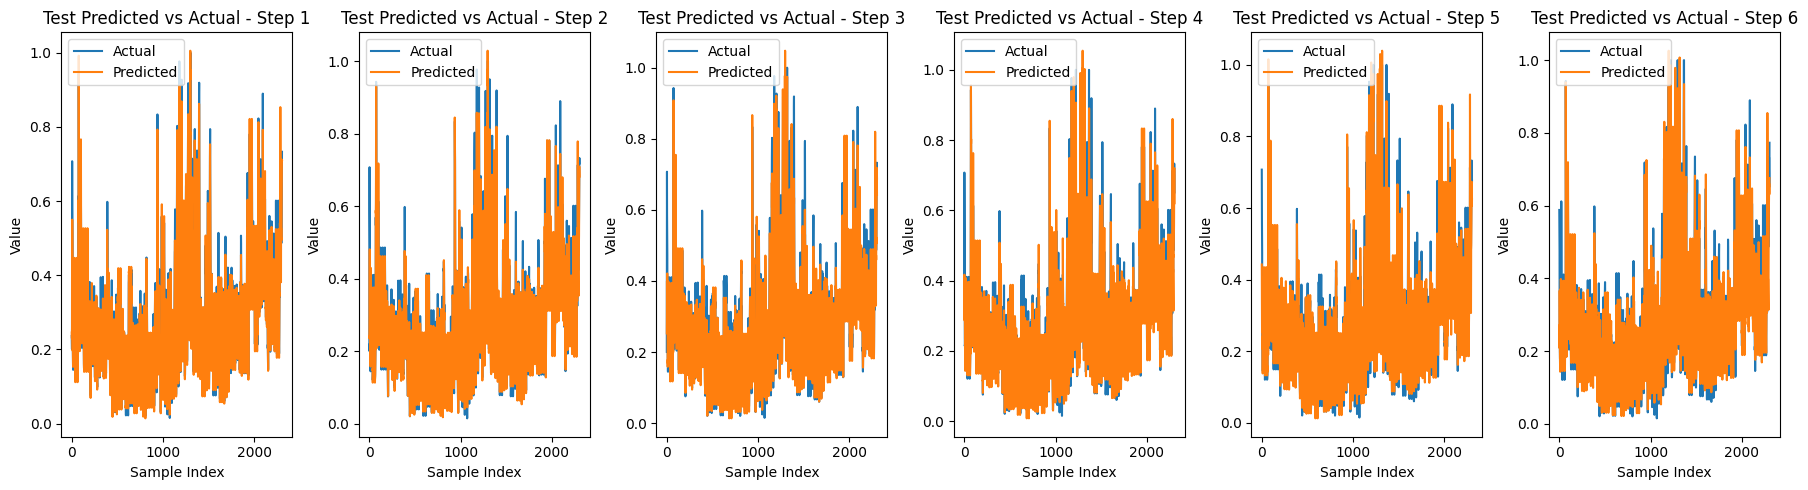

In [ ]:
# ---------------------- Plot the training process of the last fold ----------------------

plt.figure(figsize=(6,3))

plt.plot(last_train_losses, label='Train Loss')
plt.plot(last_val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Val Loss over Epochs (last run)')
plt.legend()

# ---------------------- predicted vs actual across steps ----------------------
output_dim = test_mse_per_output_all.shape[1]

plt.figure(figsize=(18, 5))
for i in range(output_dim):
    plt.subplot(1, output_dim, i+1)
    plt.plot(y_true_test_final[:, i], label='Actual')
    plt.plot(y_pred_test_final[:, i], label='Predicted')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'Test Predicted vs Actual - Step {i+1}')
    plt.legend()
plt.tight_layout()
plt.show()